# Comparisons between different experiments

Install cmocean library (just once) to add some nice color map functionality

In [1]:
#!pip install cmocean

# Morphometrics

In [2]:
import os
import math
import h5py
import errno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import xml.etree.ElementTree as ETO
from scipy.interpolate import RectBivariateSpline
import cmocean as cmo
from matplotlib import cm
from pylab import rcParams
import warnings
from scipy import signal
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from mpl_toolkits.axes_grid1 import make_axes_locatable

Here we create the function to compute the gradient and aspect parameters 

In [3]:
def loadDataFile(folder=None, timestep=0, dx=None):
        """
        Read the HDF5 file for a given time step and build slope and aspect
        
        Parameters
        ----------
        variable : folder
            Folder path to Badlands outputs.
            
        variable : timestep
            Time step to load.
            
        variable: dx
            Discretisation value in metres.

        """
        azimuth=315.0
        altitude=45.0
        
        if not os.path.isdir(folder):
            raise RuntimeError('The given folder cannot be found or the path is incomplete.')
        
        df = h5py.File('%s/tin.time%s.p%s.hdf5'%(folder, timestep, 0), 'r')
        coords = np.array((df['/coords']))
        x, y, z = np.hsplit(coords, 3)
        
        if dx is None:
            dx = (x[1]-x[0])[0]
            print 'Set dx to:',dx
        nx = int((x.max() - x.min())/dx+1)
        ny = int((y.max() - y.min())/dx+1)
        xi = np.linspace(x.min(), x.max(), nx)
        yi = np.linspace(y.min(), y.max(), ny)
        
        xi, yi = np.meshgrid(xi, yi)
        xyi = np.dstack([xi.flatten(), yi.flatten()])[0]
        XY = np.column_stack((x,y))
        tree = cKDTree(XY)
        distances, indices = tree.query(xyi, k=3)
        z_vals = z[indices][:,:,0]
        zi = np.average(z_vals,weights=(1./distances), axis=1)

        onIDs = np.where(distances[:,0] == 0)[0]
        if len(onIDs) > 0:
            zi[onIDs] = z[indices[onIDs,0]]

        z = np.reshape(zi,(ny,nx))
        
        # Calculate gradient
        Sx, Sy = np.gradient(z)
        
        rad2deg = 180.0 / np.pi
        slope = 90. - np.arctan(np.sqrt(Sx**2 + Sy**2))*rad2deg
        slp = np.sqrt(Sx**2 + Sy**2)
        
        aspect = np.arctan2(-Sx, Sy)
        deg2rad = np.pi / 180.0
        shaded = np.sin(altitude*deg2rad) * np.sin(slope*deg2rad) \
                 + np.cos(altitude*deg2rad) * np.cos(slope*deg2rad) \
                 * np.cos((azimuth - 90.0)*deg2rad - aspect)

        shaded = shaded * 255
        
        return shaded, xi, yi, z

def gaussianFilter(sizex,sizey=None,scale=0.333):
    '''
    Generate and return a 2D Gaussian function
    of dimensions (sizex,sizey)

    If sizey is not set, it defaults to sizex
    A scale can be defined to widen the function (default = 0.333)
    '''
    sizey = sizey or sizex
    x, y = np.mgrid[-sizex:sizex+1, -sizey:sizey+1]
    g = np.exp(-scale*(x**2/float(sizex)+y**2/float(sizey)))
    
    return g/g.sum()

def smoothData(dem, smth=2):
    '''
    Calculate the slope and gradient of a DEM
    '''
    
    gaussZ = np.zeros((dem.shape[0]+6,dem.shape[1]+6))
    gaussZ[3:-3,3:-3] = dem

    f0 = gaussianFilter(smth)
    smoothDEM = signal.convolve(gaussZ,f0,mode='valid')
#     f1 = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
#     f2 = f1.transpose()
#     g1 = signal.convolve(smoothDEM,f1,mode='valid')
#     g2 = signal.convolve(smoothDEM,f2,mode='valid')
#     slope = np.sqrt(g1**2 + g2**2)
#     aspect = np.arctan2(g2,g1)
    
    return smoothDEM[1:-1,1:-1] #, slope, aspect


def assignBCs(z,nx,ny):
    """
    Pads the boundaries of a grid. Boundary condition pads the boundaries
    with equivalent values to the data margins, e.g. x[-1,1] = x[1,1].
    It creates a grid 2 rows and 2 columns larger than the input.
    """
    Zbc = np.zeros((nx + 2, ny + 2))
    Zbc[1:-1,1:-1] = z

    # Assign boundary conditions - sides
    Zbc[0, 1:-1] = z[0, :]
    Zbc[-1, 1:-1] = z[-1, :]
    Zbc[1:-1, 0] = z[:, 0]
    Zbc[1:-1, -1] = z[:,-1]

    # Assign boundary conditions - corners
    Zbc[0, 0] = z[0, 0]
    Zbc[0, -1] = z[0, -1]
    Zbc[-1, 0] = z[-1, 0]
    Zbc[-1, -1] = z[-1, 0]

    return Zbc

def cmptParams(x,y,Z):
    """
    Define aspect, gradient and horizontal/vertical curvature using a
    quadratic polynomial method.
    """

    # Assign boundary conditions
    Zbc = assignBCs(Z,x.shape[0],x.shape[1])
    
    # Neighborhood definition
    # z1     z2     z3
    # z4     z5     z6
    # z7     z8     z9
    
    z1 = Zbc[2:, :-2]
    z2 = Zbc[2:,1:-1]
    z3 = Zbc[2:,2:]
    z4 = Zbc[1:-1, :-2]
    z5 = Zbc[1:-1,1:-1]
    z6 = Zbc[1:-1, 2:]
    z7 = Zbc[:-2, :-2]
    z8 = Zbc[:-2, 1:-1]
    z9 = Zbc[:-2, 2:]

    # Compute coefficient values
    dx = x[0,1]-x[0,0]
    zz = z2+z5
    r = ((z1+z3+z4+z6+z7+z9)-2.*(z2+z5+z8))/(3. * dx**2)
    t = ((z1+z2+z3+z7+z8+z9)-2.*(z4+z5+z6))/(3. * dx**2)
    s = (z3+z7-z1-z9)/(4. * dx**2)
    p = (z3+z6+z9-z1-z4-z7)/(6.*dx)
    q = (z1+z2+z3-z7-z8-z9)/(6.*dx)
    u = (5.*z1+2.*(z2+z4+z6+z8)-z1-z3-z7-z9)/9.
    #
    with np.errstate(invalid='ignore',divide='ignore'):
        grad = np.arctan(np.sqrt(p**2+q**2))
        aspect = np.arctan(q/p)
        hcurv = -(r*q**2-2.*p*q*s+t*p**2) / \
                ((p**2+q**2)*np.sqrt(1+p**2+q**2))
        vcurv = -(r*p**2+2.*p*q*s+t*q**2) /  \
                ((p**2+q**2)*np.sqrt(1+p**2+q**2))

        return grad, aspect, hcurv, vcurv

## Call the function for first experiment

In [4]:
# Regular grid interpolation resolution
dx = 100
# Time step of the experiment (get it from paraview) 48 is the last time step 2500 years
timestep = 48

shaded1, xi1, yi1, z1 = loadDataFile('../PrecipitationOutput3/h5',timestep,dx)
z_gauss1 = smoothData(z1, smth=2)
dataExtent = [np.amin(xi1), np.amax(xi1), np.amin(yi1), np.amax(yi1)]
slp1, aspect1, hcurv1, vcurv1 = cmptParams(xi1, yi1, z_gauss1)

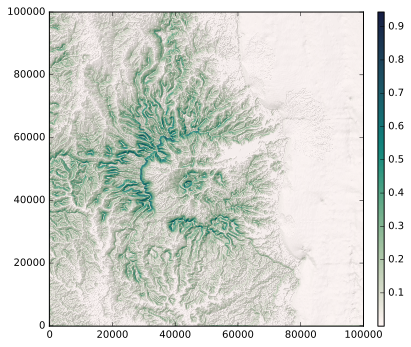

In [9]:
fig = plt.figure()
rcParams['figure.figsize'] = (6,7)
ax=plt.gca()
f2 = plt.imshow(np.flipud(slp1), interpolation = 'bilinear',
                cmap=cmo.cm.tempo, extent=dataExtent)

f1 = plt.imshow(np.flipud(shaded1), interpolation = 'bilinear',
                cmap='gray', alpha = 0.2, extent=dataExtent)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.2)

plt.colorbar(f2,cax=cax)
plt.show()

## Call the function for second experiment

In [6]:
# Regular grid interpolation resolution
dx = 100
# Time step of the experiment (get it from paraview) 48 is the last time step 2500 years
timestep = 48

shaded2, xi2, yi2, z2 = loadDataFile('../PrecipitationOutput/h5',timestep,dx)
z_gauss2 = smoothData(z2, smth=2)
dataExtent = [np.amin(xi2), np.amax(xi2), np.amin(yi2), np.amax(yi2)]
slp2, aspect2, hcurv2, vcurv2 = cmptParams(xi2, yi2, z_gauss2)

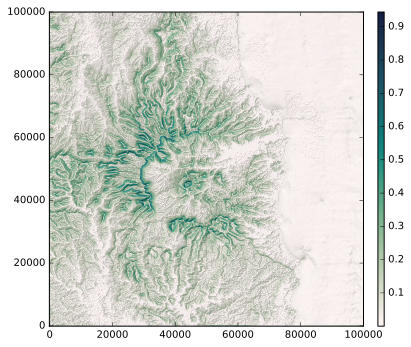

In [8]:
fig = plt.figure()
rcParams['figure.figsize'] = (6,7)
ax=plt.gca()
f2 = plt.imshow(np.flipud(slp2), interpolation = 'bilinear',
                cmap=cmo.cm.tempo, extent=dataExtent)

f1 = plt.imshow(np.flipud(shaded2), interpolation = 'bilinear',
                cmap='gray', alpha = 0.2, extent=dataExtent)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.2)

plt.colorbar(f2,cax=cax)
plt.show()

# Difference in elevation between the 2 experiments

In [11]:
diff = z2-z1
diff_smth = smoothData(diff, smth=2)

In [16]:
diff_smth.shape

(1002, 1002)

In [19]:
clip_diff = diff_smth[200:400,600:900]
clip_shaded = shaded2[200:400,600:900]

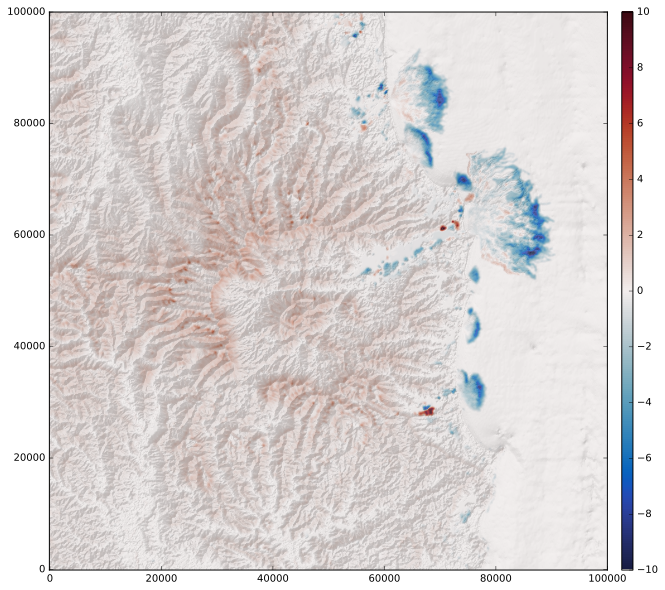

In [14]:
fig = plt.figure()
rcParams['figure.figsize'] = (12,14)
ax=plt.gca()
f2 = plt.imshow(np.flipud(diff_smth), interpolation = 'bilinear',cmap=cmo.cm.balance, 
                   vmin=-10, vmax=10, extent=dataExtent)

f1 = plt.imshow(np.flipud(shaded2), interpolation = 'bilinear',
                cmap='gray', alpha = 0.2, extent=dataExtent)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.2)

plt.colorbar(f2,cax=cax)
plt.show()

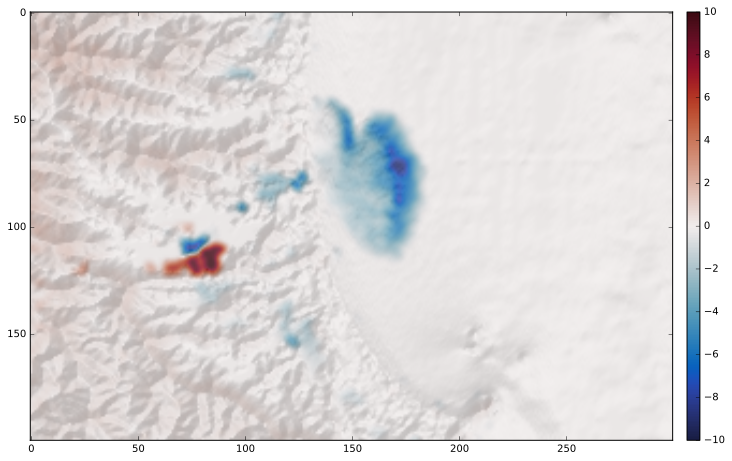

In [21]:
fig = plt.figure()
rcParams['figure.figsize'] = (10,12)
ax=plt.gca()
f2 = plt.imshow(np.flipud(clip_diff), interpolation = 'bilinear',cmap=cmo.cm.balance, 
                   vmin=-10, vmax=10)

f1 = plt.imshow(np.flipud(clip_shaded), interpolation = 'bilinear',
                cmap='gray', alpha = 0.2)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.2)

plt.colorbar(f2,cax=cax)
plt.show()

# Create CSV file

## Write the output to a file

In [22]:
# This needs to be changed otherwise it will rewrite on top of the existing file
filename = 'diff_exp1-2.csv'

In [25]:
df = pd.DataFrame({'X':xi1.flatten(),'Y':yi1.flatten(),'Z':z_gauss1.flatten(), 
                   'dz':diff_smth.flatten()})
df.to_csv(filename,columns=['X', 'Y', 'Z', 'dz'], sep=',', index=False)